## **A/B Testing** - Product Update

The data is from over 90,000 players that installed the game while the AB-test was running on a possible product update of Ad-placemnet.
As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. This project, analyzes the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, the impact on player retention and game rounds.


### Data Description 

<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after installation
<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. </p>

#### Table of Contents

1. Exploratory Data Analysis
2. Handling Data Quality issues (Missing Value, Outliers, Unexpected Value)
3. Apply hypothesis testing and check assumptions
    - Check Normality & Homogeneity
    - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
4. Evaluate the results

In [40]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
import scipy.stats as stats
import warnings
import pingouin as pg

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
data = pd.read_csv('cookie_cats.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
data.head()

userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

#### **Expolratory Data Analysis**

In [5]:
#Note that the dataset has no duplicate entries
print(data.userid.nunique())
data[data.duplicated()]

90189


Empty DataFrame
Columns: [userid, version, sum_gamerounds, retention_1, retention_7]
Index: []

In [6]:
#Assessing distribution of Sum_Gamerounds attribute
data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

count    mean      std    min     1%     5%    10%    20%  \
sum_gamerounds 90189.0000 51.8725 195.0509 0.0000 0.0000 1.0000 1.0000 3.0000   

                   50%     80%      90%      95%      99%        max  
sum_gamerounds 16.0000 67.0000 134.0000 221.0000 493.0000 49854.0000

In [7]:
#Note that the dataset is mostly balanced in terms of number of entries
data.groupby("version")["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median    mean      std    max
version                                       
gate_30  44700 17.0000 52.4563 256.7164  49854
gate_40  45489 16.0000 51.2988 103.2944   2640

In [8]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot layout: 1 row, 3 columns
fig = make_subplots(rows=1, cols=3, subplot_titles=[
    "Distribution of Gate 30 (A)",
    "Distribution of Gate 40 (B)",
    "Distribution of Two Groups"
])

# Histogram for gate_30
fig.add_trace(
    go.Histogram(
        x=data[data["version"] == "gate_30"]["sum_gamerounds"],
        marker_color='steelblue',
        name='Gate 30'
    ),
    row=1, col=1
)

# Histogram for gate_40
fig.add_trace(
    go.Histogram(
        x=data[data["version"] == "gate_40"]["sum_gamerounds"],
        marker_color='steelblue',
        name='Gate 40'
    ),
    row=1, col=2
)

# Boxplot for both groups
fig.add_trace(
    go.Box(
        x=data["version"],
        y=data["sum_gamerounds"],
        marker_color='steelblue',
        name='Boxplot'
    ),
    row=1, col=3
)

# Update layout
fig.update_layout(
    title_text="Before Removing The Extreme Value",
    title_font_size=20,
    showlegend=False,
    height=500,
    width=1100
)

fig.update_xaxes(range=[0, 1000], row=1, col=1)


In [9]:
gate_30_data = data[data.version == "gate_30"].reset_index().set_index("index")["sum_gamerounds"]
gate_40_data = data[data.version == "gate_40"].reset_index().set_index("index")["sum_gamerounds"]

# Create the figure
fig = go.Figure()

# Add line for Gate 30
fig.add_trace(go.Scatter(
    y=gate_30_data,
    x=gate_30_data.index,
    mode='lines',
    name='Gate 30'
))

# Add line for Gate 40
fig.add_trace(go.Scatter(
    y=gate_40_data,
    x=gate_40_data.index,
    mode='lines',
    name='Gate 40'
))

# Update layout
fig.update_layout(
    title="Before Removing The Extreme Value",
    title_font_size=20,
    xaxis_title="Index",
    yaxis_title="Sum of Gamerounds",
    height=500,
    width=1000,
    legend=dict(x=0.01, y=0.99)
)

fig.show()


In [27]:
#since we have a small set of outliers which are skewing the dataset, we will examine the usage outcomes by excluding these extreme values
data_without_outlier = data[data.sum_gamerounds < data.sum_gamerounds.max()]

data_without_outlier.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

count    mean      std    min     1%     5%    10%    20%  \
sum_gamerounds 90188.0000 51.3203 102.6827 0.0000 0.0000 1.0000 1.0000 3.0000   

                   50%     80%      90%      95%      99%       max  
sum_gamerounds 16.0000 67.0000 134.0000 221.0000 493.0000 2961.0000

In [28]:
fig = make_subplots(rows=1, cols=4, subplot_titles=[
    "Distribution of Total Game Rounds",
    "Distribution of Gate 30 (A)",
    "Distribution of Gate 40 (B)",
    "Distribution of Two Groups"
])

# Histogram: Total Game Rounds
fig.add_trace(
    go.Histogram(
        x=data_without_outlier["sum_gamerounds"],
        marker_color='steelblue',
        name='Total'
    ),
    row=1, col=1
)

# Histogram: Gate 30
fig.add_trace(
    go.Histogram(
        x=data_without_outlier[data_without_outlier["version"] == "gate_30"]["sum_gamerounds"],
        marker_color='steelblue',
        name='Gate 30'
    ),
    row=1, col=2
)

# Histogram: Gate 40
fig.add_trace(
    go.Histogram(
        x=data_without_outlier[data_without_outlier["version"] == "gate_40"]["sum_gamerounds"],
        marker_color='steelblue',
        name='Gate 40'
    ),
    row=1, col=3
)

# Boxplot: Gate 30 vs Gate 40
fig.add_trace(
    go.Box(
        x=data_without_outlier["version"],
        y=data_without_outlier["sum_gamerounds"],
        marker_color='steelblue',
        name='Boxplot'
    ),
    row=1, col=4
)

# Update layout
fig.update_layout(
    title="After Removing The Extreme Value",
    title_font_size=20,
    showlegend=False,
    height=500,
    width=1300
)

fig.show()


In [29]:
df_plot = data_without_outlier[data_without_outlier["version"].isin(["gate_30", "gate_40"])].copy()
df_plot = df_plot.reset_index().rename(columns={"index": "record_id"})

# Line plot using Plotly Express
fig = px.line(
    df_plot,
    x="record_id",
    y="sum_gamerounds",
    color="version",
    labels={"record_id": "Index", "sum_gamerounds": "Sum of Gamerounds", "version": "Version"},
    title="After Removing The Extreme Value"
)

fig.update_traces(opacity=0.8)  # Equivalent to `alpha = 0.8` in matplotlib
fig.update_layout(width=1100, height=500)

fig.show()


#### **Some Peculiarities**

**The users installed the game but 3994 users never played the game!** Some reasons might explain this situation.

- They have no free time to play game
- Users might prefer to play other games or they play other games already
- Some users don't like the app etc.

**The number of users decreases as the levels progress**

- Most of users played the game at early stage and they didn't progress.
- Tactile Entertainment should learn why users churn playing the game.
- Doing research and collecting data about the game and users would help to understand user churn
- The difficulty of the game can be measured

In [30]:
# Grouping the data
grouped = data_without_outlier.groupby("sum_gamerounds").userid.count()
grouped_limited = grouped[:200]  # First 200 game rounds

# Create subplots: 2 rows, 1 column
fig = make_subplots(rows=2, cols=1, subplot_titles=[
    "How many users are there all game rounds?",
    "How many users are there first 200 game rounds?"
])

# Plot 1: All game rounds
fig.add_trace(
    go.Scatter(
        x=grouped.index,
        y=grouped.values,
        mode='lines',
        name='All Game Rounds'
    ),
    row=1, col=1
)

# Plot 2: First 200 game rounds
fig.add_trace(
    go.Scatter(
        x=grouped_limited.index,
        y=grouped_limited.values,
        mode='lines',
        name='First 200 Game Rounds'
    ),
    row=2, col=1
)

# Update layout
fig.update_layout(
    title="The number of users in the game rounds played",
    title_font_size=25,
    height=800,
    width=1200,
    showlegend=False
)

fig.show()


In [31]:
#only a small number of users reached gate 30 & gate 40 levels
data_without_outlier.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

Looking at the summary statistics, the control and Test groups seem similar, but are the two groups statistically significant? We will investigate this statistically.

In [32]:
# A/B Groups & Target Summary Stats
data_without_outlier.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version                                      
gate_30  44699 17.0000 51.3421 102.0576  2961
gate_40  45489 16.0000 51.2988 103.2944  2640

**Retention variables gives us player retention details.**

<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>

Also players tend not to play the game! There are many players who quit the game.

- 55 percent of the players didn't play the game 1 day after insalling
- 81 percent of the players didn't play the game 7 day after insalling

In [33]:
# Retention metrics
pd.DataFrame({"RET1_COUNT": data_without_outlier["retention_1"].value_counts(),
              "RET7_COUNT": data_without_outlier["retention_7"].value_counts(),
              "RET1_RATIO": data_without_outlier["retention_1"].value_counts() / len(data_without_outlier),
              "RET7_RATIO": data_without_outlier["retention_7"].value_counts() / len(data_without_outlier)})

RET1_COUNT  RET7_COUNT  RET1_RATIO  RET7_RATIO
False       50035       73408      0.5548      0.8139
True        40153       16780      0.4452      0.1861

Looking at the summary statistics of retention variables by version and comparing with sum_gamerounds, there are similarities between groups. However, it will be more helpful to see if there is a statistically significant difference.

In [34]:
data_without_outlier.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640

In [35]:
data_without_outlier.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8501 105.0000 160.1175 179.3586  2961
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294

Similar results are seen when the number of users who came and did not come 1 day and 7 days after the game was installing. Approximately 12.000 users among the total users played the game both 1 day and 7 days after installing the game. 14% of the total users include people who will continue the game in the future.

In [36]:
data_without_outlier["Retention"] = np.where((data_without_outlier.retention_1 == True) & (data_without_outlier.retention_7 == True), 1,0)
data_without_outlier.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

/var/folders/xj/qwscmjj15k728nxqzq4pp9b40000gn/T/ipykernel_64467/1196496940.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

When the retention variables are combined and the two groups are compared, the summary statistics are similar here as well.

In [37]:
data_without_outlier["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), data_without_outlier.retention_1, data_without_outlier.retention_7))
data_without_outlier.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

/var/folders/xj/qwscmjj15k728nxqzq4pp9b40000gn/T/ipykernel_64467/3551406864.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



version NewRetention  count   median     mean      std   max
0  gate_30  False-False  22840   6.0000  11.8197  21.6426   981
1  gate_30   False-True   1825  43.0000  73.1693  93.2223  1072
2  gate_30   True-False  13358  33.0000  49.6945  58.1254   918
3  gate_30    True-True   6676 127.0000 183.8863 189.6264  2961
4  gate_40  False-False  23597   6.0000  11.9133  20.9010   547
5  gate_40   False-True   1773  47.0000  75.2611  94.4780  1241
6  gate_40   True-False  13613  32.0000  50.0255  60.9246  2640
7  gate_40    True-True   6506 133.0000 190.2824 194.2201  2294

#### **A/B Testing**

Assumptions:
- Check normality
- If Normal Distribution, check homogeneity

<br>

Tests to assess differntial impact:
- Split & Define Control Group & Test Group
- Apply Shapiro Test for normality
- If parametric apply Levene Test for homogeneity of variances
- If Parametric + homogeneity of variances apply T-Test
- If Parametric - homogeneity of variances apply Welch Test
- If Non-parametric apply Mann Whitney U Test directly

<br>

H0 : No difference in user behaviour upon change in Ad Placement
Ha : Difference exists in user behaviour upon change in Ad Placement

In [41]:
# performing Cohen's d test to see if the difference is statistically significant, how big is that difference
cohens_d = pg.compute_effsize(
    data_without_outlier[data_without_outlier.version == "gate_30"]["sum_gamerounds"],
    data_without_outlier[data_without_outlier.version == "gate_40"]["sum_gamerounds"],
    eftype='cohen'
)
print(f"Cohen's d: {cohens_d:.3f}")

Cohen's d: 0.000


In [42]:
# Normality check
normality_results = data_without_outlier.groupby('version')['sum_gamerounds'].apply(pg.normality)
print(f"Normality Result: {normality_results}")

# Homogeneity of variance
levene_result = pg.homoscedasticity(data_without_outlier, dv='sum_gamerounds', group='version')
print(levene_result)

Normality Result:                      W   pval  normal
version                              
gate_30 gate_30 0.4886 0.0000   False
gate_40 gate_40 0.4826 0.0000   False
            W   pval  equal_var
levene 0.0751 0.7840       True


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44699.

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45489.



In [43]:
# Choose appropriate test
if all(normality_results['normal']) and levene_result['equal_var'][0]:
    test = pg.ttest(data_without_outlier[data_without_outlier.version == "gate_30"]["sum_gamerounds"],
                    data_without_outlier[data_without_outlier.version == "gate_40"]["sum_gamerounds"],
                    correction=False)  # Student's t-test
    test_name = "Independent t-test"
else:
    test = pg.mwu(data_without_outlier[data_without_outlier.version == "gate_30"]["sum_gamerounds"],
                  data_without_outlier[data_without_outlier.version == "gate_40"]["sum_gamerounds"])
    test_name = "Mann-Whitney U test"

print(f"\n{test_name} Results:\n", test)


Mann-Whitney U test Results:
               U-val alternative  p-val    RBC   CLES
MWU 1024285761.5000   two-sided 0.0509 0.0075 0.5038


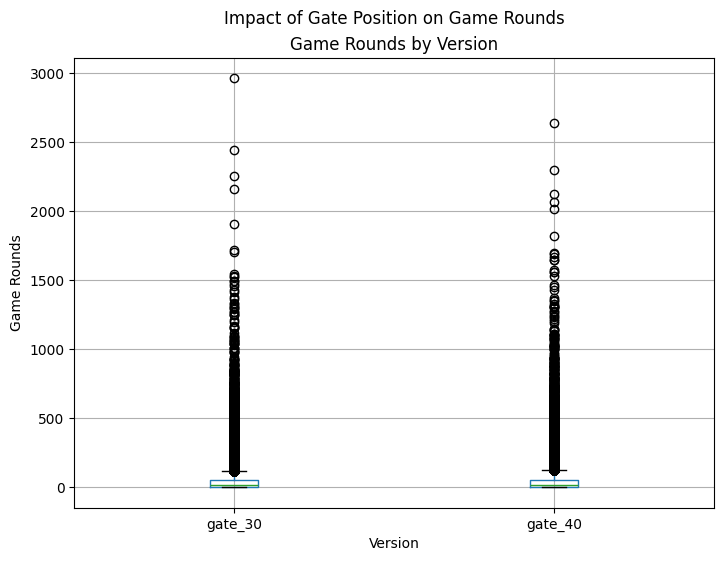

In [45]:
# Visualize with boxplot
data_without_outlier.boxplot(column="sum_gamerounds", by="version", figsize=(8,6))
plt.title("Game Rounds by Version")
plt.suptitle("Impact of Gate Position on Game Rounds")
plt.xlabel("Version")
plt.ylabel("Game Rounds")
plt.show()

#### **Conclusion: Gate 30 vs Gate 40**

Test Summary
- **Data**: 90,189 users; balanced across groups; outliers present in both.
- **Distribution**: Skewed with outliers → non-normal.
- **Assumption Checks**:
  - Normality: ❌ Failed
  - Equal variances: ❌ Failed
- **Test Used**: Mann-Whitney U (non-parametric)

#### 🧪 Mann-Whitney U Results:
- **U-value**: 1,024,285,761.5  
- **p-value**: 0.0509  
- **Effect size (RBC)**: 0.0075 (negligible)  
- **Common Language Effect Size (CLES)**: 0.5038

<br>

**Conclusion**

- The difference in game rounds between `gate_30` and `gate_40` is **not statistically significant**, even though on the borderline of the threshold (p = 0.0509).
- **Effect size is negligible** (RBC = 0.0075), indicating no meaningful behavioral change.
- Visually and statistically, both versions yield **similar user engagement**.

<br>

**Recommendation**

Maintain the current version (`gate_30`), as moving the gate offers **no practical improvement** in player engagement.
